   <h1 align="center"> <font color='#CF8305'>Introduction</font> <h1> 

<div class="alert alert-block alert-info">
    <b></b> Bonjour.
Pour rappel je suis consultant Data Analyst dans une entreprise spécialisée dans la data. Mon entreprise a décroché une prestation en régie au sein de l’Organisation nationale de lutte contre le faux-monnayage (ONCFM).
Cette institution a pour objectif de mettre en place des méthodes d’identification des contrefaçons c'est dans ce context qu'elle nous a fait appel pour mettre en place une modélisation qui serait capable d’identifier automatiquement les vrais des faux billets. Et ce à partir simplement de certaines dimensions du billet et des éléments qui le composent.
        </div>

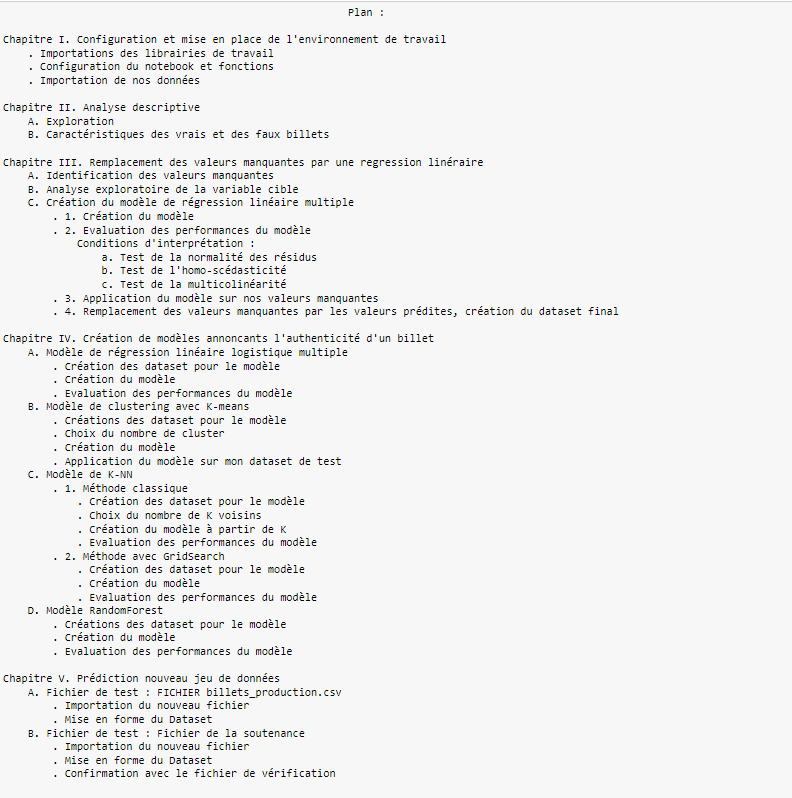

> *Dans un premier temps nous allons explorer nos données, comprendre les caractéristiques de l'authenticité des billets. Puis dans un second temps nous allons remplacer les valeurs manquantes que nous allons repérer par un modèle de machine learning. Dans un troisième temps je présenterais plusieurs modèles permettant de prédire les futures billets. Enfin dans un dernier temps j'appliquerai ces différents modèles sur les nouveaux billets ajouter lors de cette session.*

<h1 align="center"> <font color='#CF8305'>I. Configuration et mise en place de l'environnement de travail</font>  <h1> 

<h4 align="center"> <font color='#CF8305'>Importation des librairies de travail</font>  <h4> 

In [93]:
# Importation de la librairie Pandas et numpy
import pandas as pd
import numpy as np

# Importation eviter les messages rouges d'erreurs
import warnings
warnings.filterwarnings("ignore")

# Importation datetime
from datetime import datetime
from datetime import date

# Import librairies pour la visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Normalisation
from sklearn.preprocessing import StandardScaler

# Regression linéaire
from sklearn import metrics

# Condition interprétation
import statsmodels.formula.api as smf
from scipy.stats import t, shapiro
import statsmodels.stats.diagnostic as smd
from statsmodels.stats.outliers_influence import variance_inflation_factor


# Import pour modèle de regression logistique
from sklearn.linear_model import LogisticRegression

# Import méthode silhouette
from sklearn import cluster, metrics

# Import méthode coude et K means
from sklearn.cluster import KMeans

# KNN
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Random forest
from sklearn.ensemble import RandomForestClassifier

<h4 align="center"> <font color='#CF8305'> Configuration du notebook et fonctions </font> <h4> 

In [94]:
# Configuration du display options afficher toutes les lignes
pd.set_option("display.max_rows", None)

<h4 align="center"> <font color='#CF8305'> Importation de nos données </font> <h4> 

In [95]:
# Importation de la table de travail

df = pd.read_csv('C:/Users/User/Desktop/Projet_10/Donnees/billets.csv', sep=';')

<h1 align="center"> <font color='#CF8305'> II. Analyse descriptive </font> <h1> 

<h2 align="center"> <font color='#CF8305'> A. Exploration </font> <h2> 

In [96]:
# Afficher les dimensions du dataset

df.shape

(1500, 7)

In [97]:
# La nature des données dans chacune des colonnes

df.dtypes

is_genuine         bool
diagonal        float64
height_left     float64
height_right    float64
margin_low      float64
margin_up       float64
length          float64
dtype: object

In [98]:
# Vérification pas de valeurs abéranttes dans les min et max par exemple 

df.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


In [99]:
#Vérification qu'il n'y ait pas de doublons / compte le nombre de ligne en doublon

print(df.duplicated().sum())

0


In [100]:
# Vérification qu'il n'y ait pas de valeur nulle
# Ici 37 valeurs nulls dans la colonne margin_low, on va revenir dessus

df.isna().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

In [101]:
# Affichage des 5 premières lignes de la table

df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


                                             Définition des variables :

- lenght : la longueur du billet (en mm)
- height_right : la hauteur du billet sur le côté droit (en mm)
- height_left : la hauteur du billet sur le côté gauche (en mm)
- margin_low : la marge entre le bord inférieur du billet et l'image (en mm)
- margin_up : la marge entre le bord supèrieur du billet et l'image (en mm)
- diagonal : la diagonal du billet (en mm)
- is_genuine : Savoir si le billet et authentique ou non : True il l'est, False il l'est pas. 

Note : Toutes les mesures sont en millimètres. 

In [102]:
df['is_genuine'].unique()

array([ True, False])

In [103]:
# On remplace notre variable quantitative par un flag pour pouvoir l'encoder par la suite
# is_genuine : 0: faux : 1: Vrai

df['is_genuine'].replace([False, True], [0,1], inplace=True)
df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1,171.46,103.36,103.66,3.77,2.99,113.09
2,1,172.69,104.48,103.50,4.40,2.94,113.16
3,1,171.36,103.91,103.94,3.62,3.01,113.51
4,1,171.73,104.28,103.46,4.04,3.48,112.54


In [104]:
# Vérification du nombre de vrai et de faux billets dans le dataset

print('Il y a',df.loc[df['is_genuine']==1,:]['is_genuine'].count(),'vrais billets')
print('Il y a',df.loc[df['is_genuine']==0,:]['is_genuine'].count(),'faux billets')

Il y a 1000 vrais billets
Il y a 500 faux billets


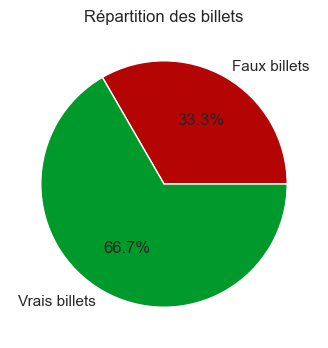

In [105]:
# Graphique : 
plt.figure(figsize=(4, 4))
plt.pie(df.groupby(["is_genuine"])["length"].count(),
        labels=["Faux billets","Vrais billets"],
        autopct="%1.1f%%", colors=["#b50404","#00992C"])
plt.title("Répartition des billets")
plt.show()

   <h2 align="center"> <font color='#CF8305'> B. Caractéristiques des vrais et des faux billets </font> <h2> 

> *On affiche toutes les possibilités des variables en nuage de points en coloriant les billets par leurs authenticité. Cela permet d'identifier visuellement certains comportements.*

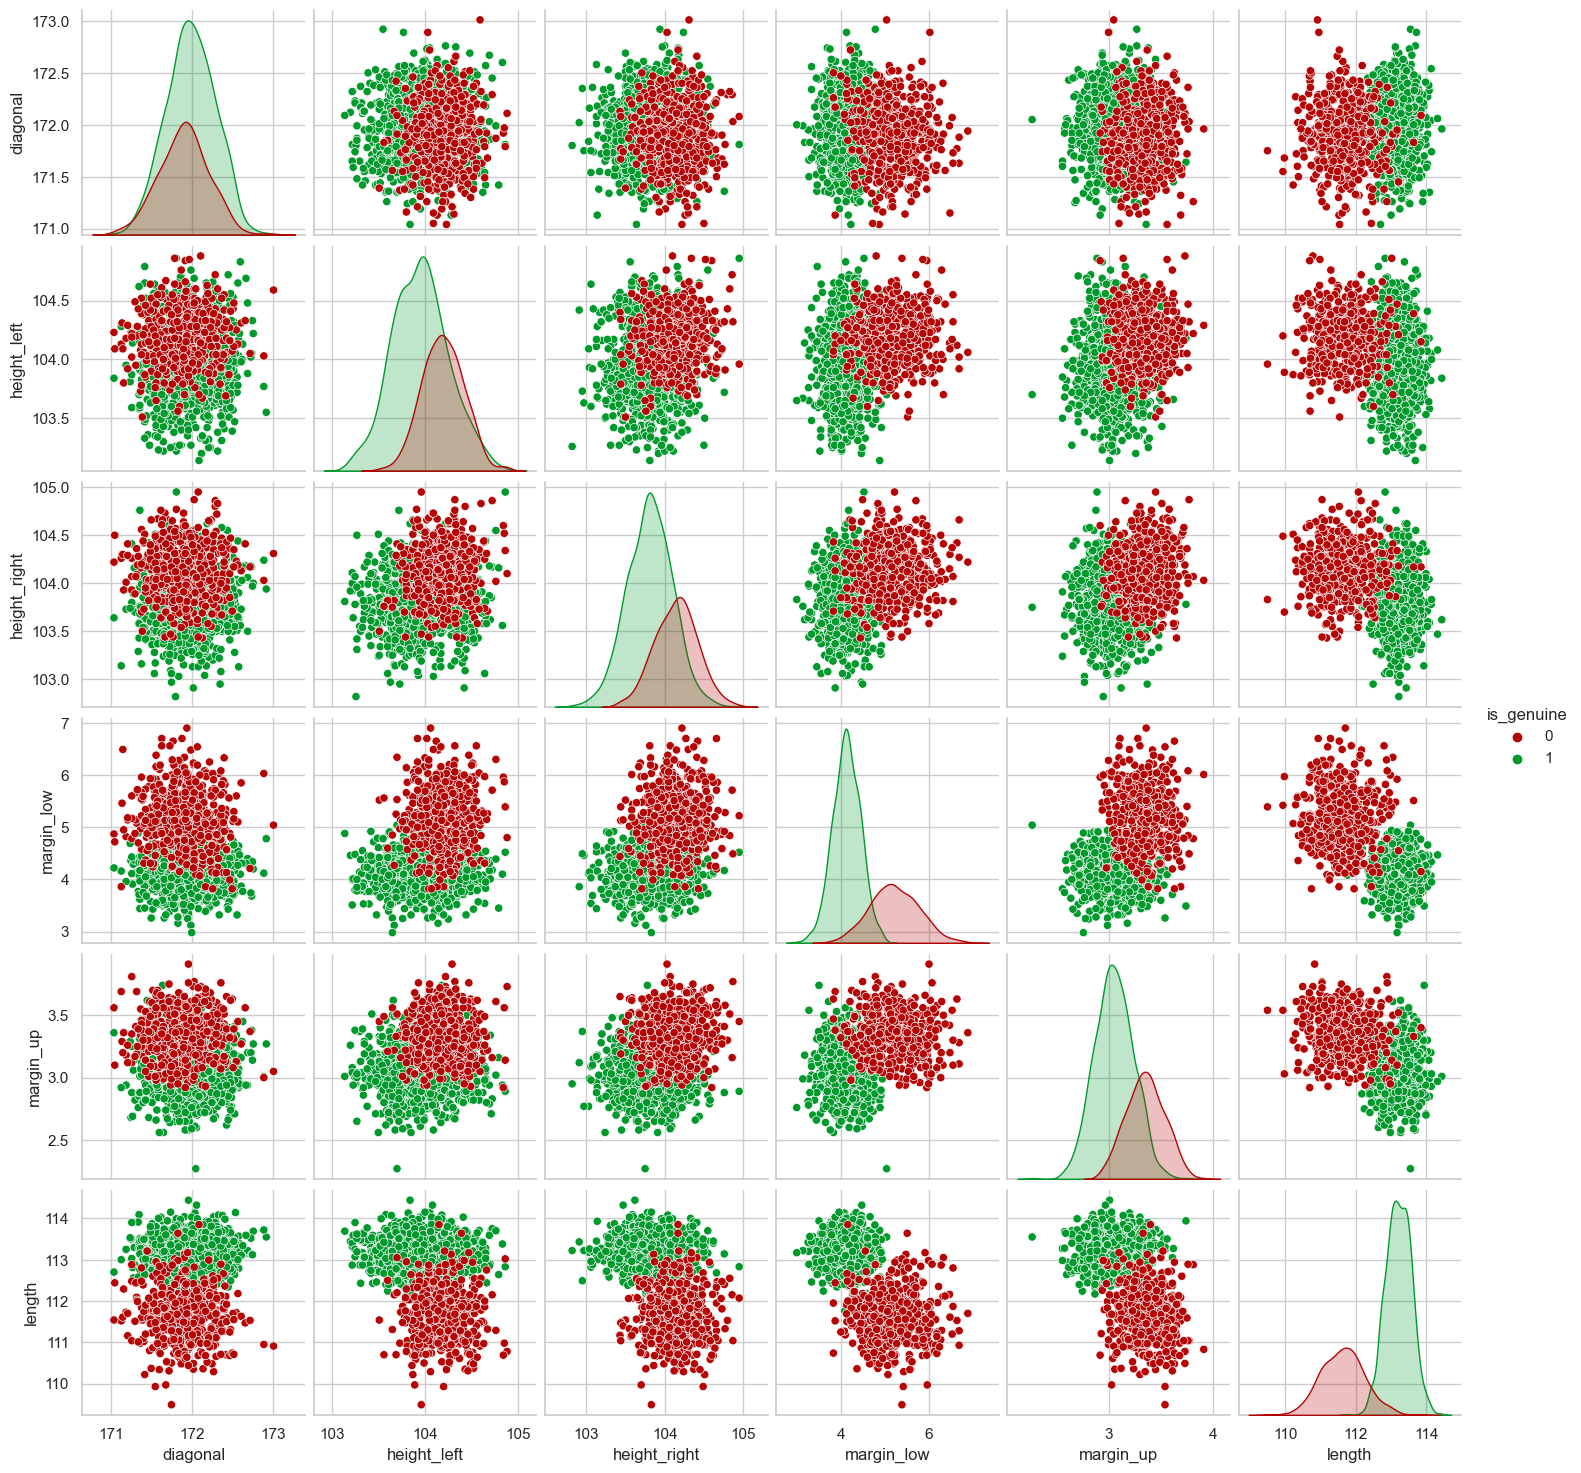

In [106]:
sns.pairplot(df, hue='is_genuine', palette=["#b50404","#00992C"])

In [107]:
# Création de deux dataframes l'un contenant les caractéristiques des vrais billets, 
# l'autre contenant les caractéristiques des faux billets. 

df_vrai = df.loc[df['is_genuine']==1,:]
df_faux = df.loc[df['is_genuine']==0,:]

<h4 align="center"> <font color='#CF8305'> Affichage des distributions des variables des vrais et des faux billets </font> <h4> 

Text(0.5, 1.0, 'diagonal faux billets')

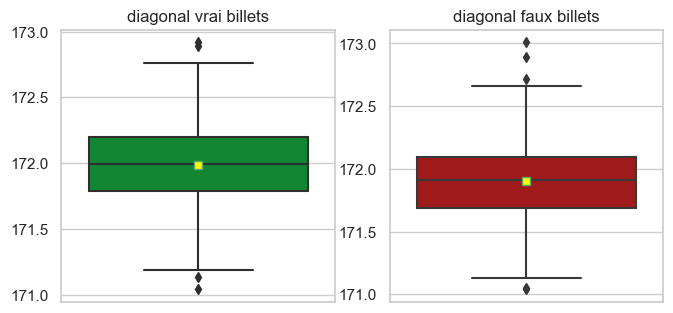

In [108]:
# Pour la variable diagonal

plt.figure(figsize=(12, 12))
sns.set(style="whitegrid")
plt.subplot(331)
sns.boxplot(data=df_vrai, y='diagonal', showmeans=True, meanprops={"marker":"s","markerfacecolor":"yellow"}, palette=["#00992C"]).set(xlabel=None, ylabel=None)
plt.title('diagonal vrai billets')  

plt.subplot(332)
sns.boxplot(data=df_faux, y='diagonal', showmeans=True, meanprops={"marker":"s","markerfacecolor":"yellow"}, palette=["#b50404"]).set(xlabel=None, ylabel=None)
plt.title('diagonal faux billets')  

Text(0.5, 1.0, 'height_left faux billets')

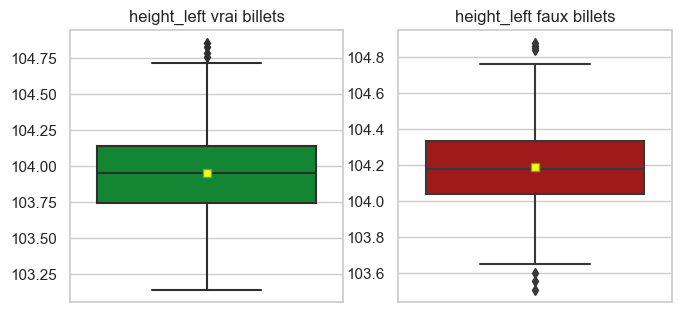

In [109]:
# Pour la variable height_left

plt.figure(figsize=(12, 12))
sns.set(style="whitegrid")
plt.subplot(331)
sns.boxplot(data=df_vrai, y='height_left', showmeans=True, meanprops={"marker":"s","markerfacecolor":"yellow"}, palette=["#00992C"]).set(xlabel=None, ylabel=None)
plt.title('height_left vrai billets')  

plt.subplot(332)
sns.boxplot(data=df_faux, y='height_left', showmeans=True, meanprops={"marker":"s","markerfacecolor":"yellow"}, palette=["#b50404"]).set(xlabel=None, ylabel=None)
plt.title('height_left faux billets')  

Text(0.5, 1.0, 'height_right faux billets')

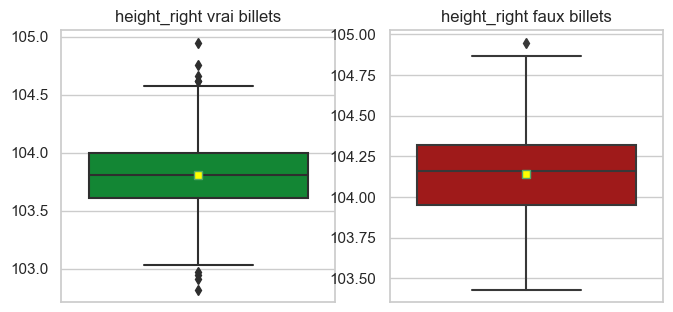

In [110]:
# Pour la variable height_right

plt.figure(figsize=(12, 12))
sns.set(style="whitegrid")
plt.subplot(331)
sns.boxplot(data=df_vrai, y='height_right', showmeans=True, meanprops={"marker":"s","markerfacecolor":"yellow"}, palette=["#00992C"]).set(xlabel=None, ylabel=None)
plt.title('height_right vrai billets')  

plt.subplot(332)
sns.boxplot(data=df_faux, y='height_right', showmeans=True, meanprops={"marker":"s","markerfacecolor":"yellow"}, palette=["#b50404"]).set(xlabel=None, ylabel=None)
plt.title('height_right faux billets')  

Text(0.5, 1.0, 'margin_low faux billets')

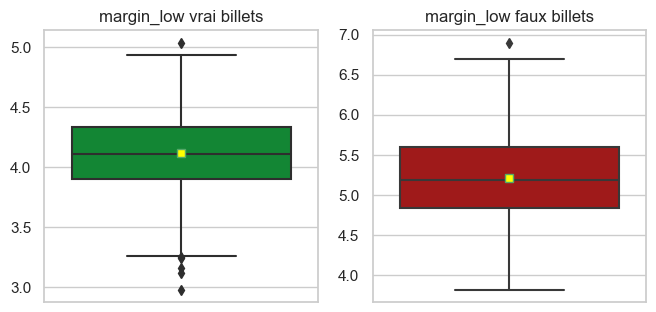

In [111]:
# Pour la variable margin_low

plt.figure(figsize=(12, 12))
sns.set(style="whitegrid")
plt.subplot(331)
sns.boxplot(data=df_vrai, y='margin_low', showmeans=True, meanprops={"marker":"s","markerfacecolor":"yellow"}, palette=["#00992C"]).set(xlabel=None, ylabel=None)
plt.title('margin_low vrai billets')  

plt.subplot(332)
sns.boxplot(data=df_faux, y='margin_low', showmeans=True, meanprops={"marker":"s","markerfacecolor":"yellow"}, palette=["#b50404"]).set(xlabel=None, ylabel=None)
plt.title('margin_low faux billets')  

Text(0.5, 1.0, 'margin_up faux billets')

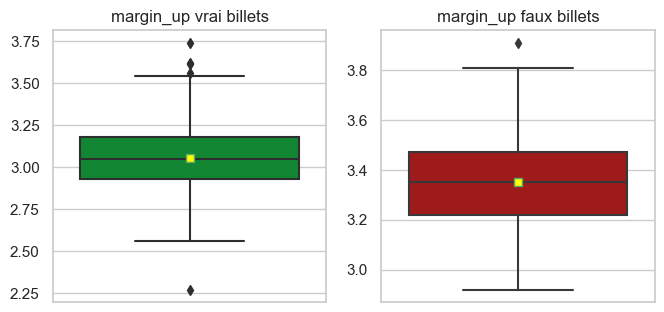

In [112]:
# Pour la variable margin_up

plt.figure(figsize=(12, 12))
sns.set(style="whitegrid")
plt.subplot(331)
sns.boxplot(data=df_vrai, y='margin_up', showmeans=True, meanprops={"marker":"s","markerfacecolor":"yellow"}, palette=["#00992C"]).set(xlabel=None, ylabel=None)
plt.title('margin_up vrai billets')  

plt.subplot(332)
sns.boxplot(data=df_faux, y='margin_up', showmeans=True, meanprops={"marker":"s","markerfacecolor":"yellow"}, palette=["#b50404"]).set(xlabel=None, ylabel=None)
plt.title('margin_up faux billets') 

Text(0.5, 1.0, 'length faux billets')

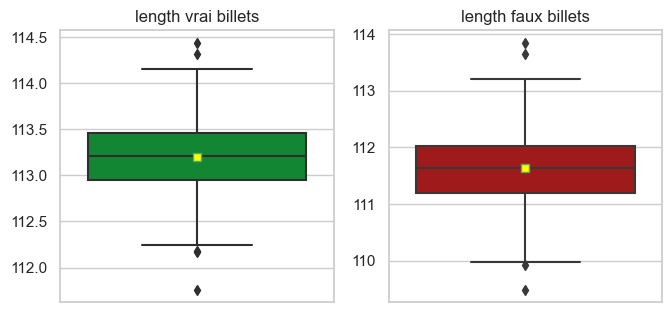

In [113]:
# Pour la variable length

plt.figure(figsize=(12, 12))
sns.set(style="whitegrid")
plt.subplot(331)
sns.boxplot(data=df_vrai, y='length', showmeans=True, meanprops={"marker":"s","markerfacecolor":"yellow"}, palette=["#00992C"]).set(xlabel=None, ylabel=None)
plt.title('length vrai billets')  

plt.subplot(332)
sns.boxplot(data=df_faux, y='length', showmeans=True, meanprops={"marker":"s","markerfacecolor":"yellow"}, palette=["#b50404"]).set(xlabel=None, ylabel=None)
plt.title('length faux billets') 

In [114]:
# Affichage du résumé (moyenne, médiane, quartiles etc...) des variables des vrais billets 

print("Information concernant les vrais billets :")
df_vrai.describe()

Information concernant les vrais billets :


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
count,1000.0,1000.000000,1000.000000,1000.00000,971.000000,1000.00000,1000.000000
mean,1.0,171.987080,103.949130,103.80865,4.116097,3.05213,113.202430
std,0.0,0.300441,0.300231,0.29157,0.319124,0.18634,0.359552
min,1.0,171.040000,103.140000,102.82000,2.980000,2.27000,111.760000
25%,1.0,171.790000,103.740000,103.61000,3.905000,2.93000,112.950000
50%,1.0,171.990000,103.950000,103.81000,4.110000,3.05000,113.205000
75%,1.0,172.200000,104.140000,104.00000,4.340000,3.18000,113.460000
max,1.0,172.920000,104.860000,104.95000,5.040000,3.74000,114.440000


In [115]:
# Affichage du résumé (moyenne, médiane, quartiles etc...) des variables des faux billets 

print("Information concernant les faux billets :")
df_faux.describe()

Information concernant les faux billets :


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
count,500.0,500.000000,500.000000,500.000000,492.000000,500.000000,500.000000
mean,0.0,171.901160,104.190340,104.143620,5.215935,3.350160,111.630640
std,0.0,0.306861,0.223758,0.270878,0.553531,0.180498,0.615543
min,0.0,171.040000,103.510000,103.430000,3.820000,2.920000,109.490000
25%,0.0,171.690000,104.040000,103.950000,4.840000,3.220000,111.200000
50%,0.0,171.910000,104.180000,104.160000,5.190000,3.350000,111.630000
75%,0.0,172.092500,104.332500,104.320000,5.592500,3.472500,112.030000
max,0.0,173.010000,104.880000,104.950000,6.900000,3.910000,113.850000


In [116]:
# On regarde la différence des moyennes des features des vrais billets et des faux billets 

# On calcule la différence de diagonale entre les vrais et les faux billets
diff_diag = (((df.loc[df["is_genuine"]==1]["diagonal"].mean())-(df.loc[df["is_genuine"]==0]["diagonal"].mean()))/(df.loc[df["is_genuine"]==1]["diagonal"].mean()))*100

# On calcule la différence de hauteur entre les vrais et les faux billets
diff_h_left = (((df.loc[df["is_genuine"]==1]["height_left"].mean())-(df.loc[df["is_genuine"]==0]["height_left"].mean()))/(df.loc[df["is_genuine"]==1]["height_left"].mean()))*100
diff_h_right = (((df.loc[df["is_genuine"]==1]["height_right"].mean())-(df.loc[df["is_genuine"]==0]["height_right"].mean()))/(df.loc[df["is_genuine"]==1]["height_right"].mean()))*100

# On calcule la différence de marge entre les vrais et les faux billets
diff_m_low = (((df.loc[df["is_genuine"]==1]["margin_low"].mean())-(df.loc[df["is_genuine"]==0]["margin_low"].mean()))/(df.loc[df["is_genuine"]==1]["margin_low"].mean()))*100
diff_m_up = (((df.loc[df["is_genuine"]==1]["margin_up"].mean())-(df.loc[df["is_genuine"]==0]["margin_up"].mean()))/(df.loc[df["is_genuine"]==1]["margin_up"].mean()))*100

# On calcule la différence de longeur entre les vrais et les faux billets
diff_length = (((df.loc[df["is_genuine"]==1]["length"].mean())-(df.loc[df["is_genuine"]==0]["length"].mean()))/(df.loc[df["is_genuine"]==1]["length"].mean()))*100


# Affichage des résultats sous forme de Tableau
pd.DataFrame(index=["Moyenne des écrats en %"],columns=["diagonale","height_left","height_right","margin_low","margin_up","length"],data=[[diff_diag, diff_h_left, diff_h_right, diff_m_low, diff_m_up, diff_length]])                                                                                                                                         

,diagonale,height_left,height_right,margin_low,margin_up,length
Moyenne des écrats en %,0.049957,-0.232046,-0.32268,-26.720415,-9.764656,1.388477


> *Observation : Les vrais billets ont une diagonale et une longueur légèrement plus importante, ils sont donc plus grands que les faux billets. Néanmoins les hauteurs des billets sont légèrement plus importants pour les faux billets. Les faux billets ont des marges plus importantes, la différence de la marge basse du billet (margin_low) est assez notable : 26% en moyenne.*  

<h1 align="center"> <font color='#CF8305'> III. Remplacement des valeurs manquantes par une regression linéraire </font> <h1> 

   <h2 align="center"> <font color='#CF8305'> A. Identification des valeurs manquantes </font> <h2> 

In [117]:
# Ici 37 valeurs nulls dans la colonne margin_low

df.isna().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

In [118]:
# On regarde la proportion de ces valeurs manquantes sur l'intégralité du dataset

Part_margin_low_Nan = round((df['margin_low'].isna().sum() / len(df)) *100,1)
Nb_margin_low_Nan = df['margin_low'].isna().sum()
print('Il y a',Nb_margin_low_Nan,'valeurs nulles dans ma variable margin_low')
print('Ce qui correspond à',Part_margin_low_Nan,'% des valeurs de ma variable margin_low de mon dataset')

Il y a 37 valeurs nulles dans ma variable margin_low
Ce qui correspond à 2.5 % des valeurs de ma variable margin_low de mon dataset


>*Nous allons traiter nos 37 valeurs manquantes de la colonne margin_low. Pour se faire plusieurs options s'offre à moi: Travailler en laissant ces données vides : ici cette possibilité n'est pas possible nous ne pourrons pas entrainer de modèle de machine learning sur des valeurs nulles. Amputer : les enlever de mon jeu de donnée. Imputer : les remplacer par une valeur. Cette valeur peut être calculer par exemple par la médiane de la variable, par la moyenne ... Ici je décide de l'imputer par une régression linéaire.*

<h2 align="center"> <font color='#CF8305'> B. Analyse exploratoire de cette variable </font> <h2> 

> *L'analyse exploratoire des données est une étape très importante avant la formation du modèle. Avant de créer notre modèle on se rend compte qu’il y a 6 variables explicatives pour margin_low. Nous devrons répondre aux questions suivantes : Dois-je choisir toutes ces variables pour mon modèle ? Quelles sont les variables qui ont une forte relation linéaire avec la variable margin_low. Pour répondre à ces interrogations on va faire une matrice de corrélation.*

<Axes: >

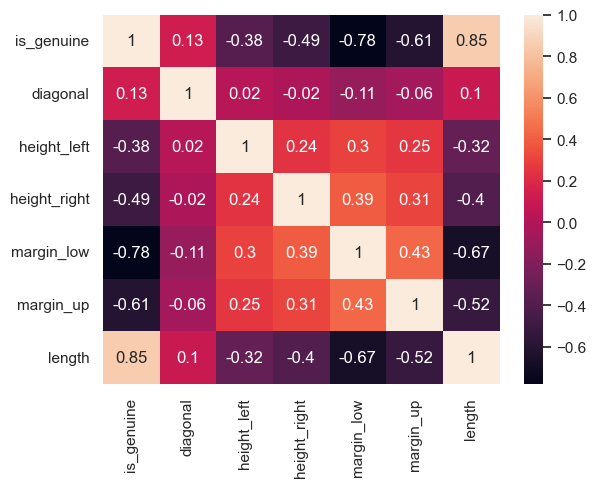

In [119]:
# Étude de la corrélation
matrice_corr = df.corr().round(2)

# Affichage de la corrélation
sns.heatmap(data = matrice_corr, annot = True)

> *En examinant la matrice de corrélation, nous pouvons voir que margin_up (0.43), height_right(0.39) et height_left(0.3) sont légèrement corrélé positivement avec margin_low. Alors que length (-0.67), et is_genuine (-0.78) ont une forte corrélation négative avec margin_low.On regarde la forme des variables explicatives par rapport à margin_low*

Text(0, 0.5, 'margin_low')

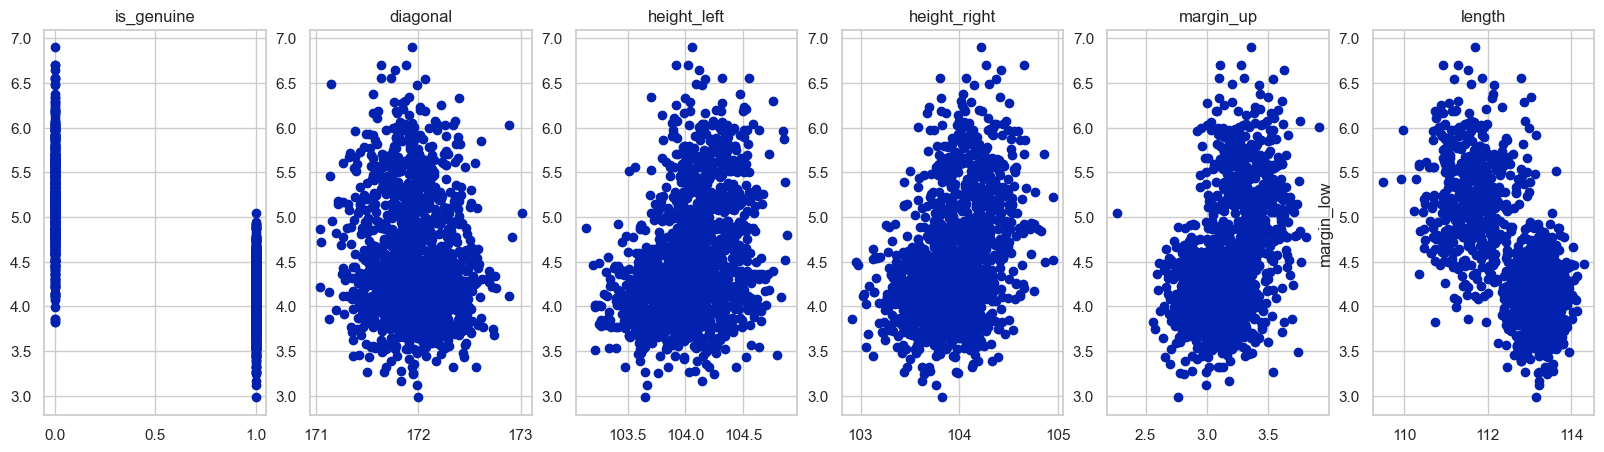

In [120]:
# Graphique des variables explicatives

plt.figure(figsize=(20, 5))
plt.title(label='Graphique des variables explicatives')

features = ['is_genuine','diagonal', 'height_left','height_right','margin_up','length']
target = df['margin_low']

for i, col in enumerate(features):
    plt.subplot(1, len(features) , i+1)

    x = df[col]
    y = target

    plt.scatter(x, y, marker='o', color="#0221AE")
    plt.title(col)

plt.ylabel('margin_low')

> *Observation: margin_low augmente à mesure que la valeur de margin_up, height_right, height_left augmente de manière linéaire. margin_low diminue à mesure que la valeur length augmente de manière linéaire.*

<h2 align="center"> <font color='#CF8305'> C. Création du modèle </font> <h2> 

In [121]:
# Création de 2 df l'un avec les valeurs manquantes l'autre sans 

df_Nan = df.loc[df['margin_low'].isna()]
df_SNan = df.dropna()

<h3 align="center"> <font color='#CF8305'> 1. Création du modèle de regression linéaire multiple </font> <h3> 

> *Afin de combler nos données manquantes, nous allons  tenter d'estimer les données manquantes 'margin_low' à partir des données des 6 autres variables.*

In [122]:
# On va d'abord créer le modèle l'entrainer et le tester avec le df ou nous avons les valeurs pour pouvoir l'évaluer puis
# nous l'appliquerons sur notre df_Nan ou il nous manque des valeurs
# Création de nos deux df au sein de celui-ci, un X avec margin_up, height_righ, height_left et y notre variable cible margin_low

X = df_SNan.drop(['margin_low'], axis=1)
y = df_SNan['margin_low']

# Séparation de ce dataset en deux, un d'entrainement, un de test. 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1)

# Création du modèle
from sklearn.linear_model import LinearRegression 
model = LinearRegression()
model.fit(X_train, y_train)

# Utilisation du modèle pour prédire y_test
y_predict = model.predict(X_test)

<h3 align="center"> <font color='#CF8305'> 2. Evaluation des performances du modèle </font> <h3> 

> *Il existe plusieurs métriques pour évaluer la performance d'un modèle de regression. Ces métriques sont basées sur les erreures entre la prédiction et les valeurs réelles. Ici nous allons juste nous concentré sur le coefficient de détermination R². Il évalue la performance du modèle par rapport au niveau de variation présent dans les données. Plus il est proche de 1 plus le modèle est bon, plus il est proche de 0 moins le modèle est bon. Le R² est malheureusement bas. Le modèle explique une faible part de la variation de notre varibale dépendante.Notre modèle de prédiction est naturellement imparfait.*

In [123]:
print('R²:', metrics.r2_score(y_test, y_predict))      

R²: 0.603774827497864


> *Afin d'interpréter les résultats de l'analyse de régression de manière significative, certaines conditions doivent être remplies.*

<h4 align="center"> <font color='#CF8305'> Conditions d'interprétation : </font> <h4> 

<h4 align="center"> <font color='#CF8305'> a. Test de la normalité des résidus </font> <h4> 

> *Notre modèle étant imparfait, essayons de représenter la "part d'erreur" de cette prédiction, c'est à dire notre prédiction moins les données réelles, observées. c'est ce qu'on appel les résidus. La condition suivante de la régression linéaire est que les résidus (l'erreur epsilon) doit être normalement distribuée. Ici nous utilisons une méthode analytique avec le test de shapiro-wilk. Si la valeur p est supérieure à 0,05, les données ne s'écartent pas de la distribution normale et l'on peut supposer que les données sont normalement distribuées.*

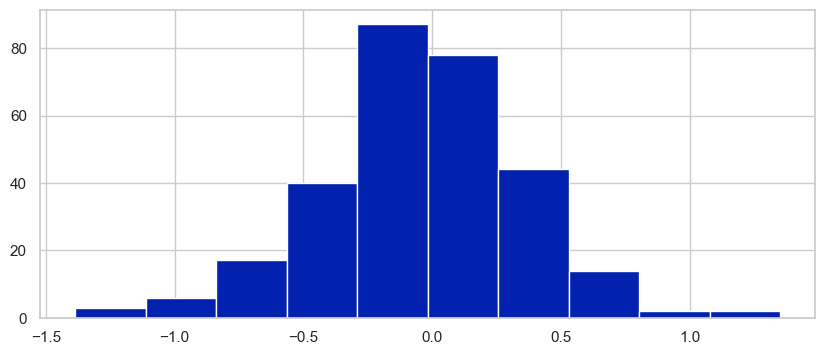

In [124]:
#display(y_test.values) # nos données réelles
#display(np.round(y_predict,2)) # nos données prédites
residus = y_test - y_predict # calculs de la différence "données réelles" - "données prédites"
#display(residus.values)

# Graphique
plt.figure(figsize=(10, 4))
plt.hist(residus, color="#0221AE")
plt.show()

In [125]:
# Test statistique de shapiro sur les résidus. 
reg_multi = smf.ols('margin_low~is_genuine+diagonal+height_left+height_right+margin_up+length', data=df_SNan).fit()
shapiro(reg_multi.resid)

ShapiroResult(statistic=0.9936949610710144, pvalue=7.050080967019312e-06)

> *Ici, l'hypothèse de normalité est remise en cause (p-value =~ 0 < 0.05). Cela étant nous avons un échantillon qui a une grande quantité d'individus (très supérieur à 30), et on observe que graphiquement, même si cela n'est pas parfait, on obtient une distribution qui se rapproche d'une distribution normale.*

 <h4 align="center"> <font color='#CF8305'> b. Test de l'homo-scédasticité </font> <h4> 

> *On peut également tester l’homoscédasticité (c'est-à-dire la constance de la variance) des résidus (des erreurs) :*

In [126]:
# Test de breusch Pagan
_, pval, __, f_pval = smd.het_breuschpagan(reg_multi.resid, reg_multi.model.exog)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 3.463957971604351e-33


> *La p-valeur ici est quasiment égale à 0, donc très inférieure à 5% : on doit rejetter l'hypothèse 𝐻0 selon laquelle les variances sont constantes (l'hypothèse d’homoscédasticité). Potentiellement, notre modèle sera peu fiable.*

 <h4 align="center"> <font color='#CF8305'> c. Test de la multicolinéarité </font> <h4> 

> *La multicolinéarité signifie que deux variables indépendantes ou plus sont fortement corrélées entre elles. Le problème de la multicolinéarité est que les effets de chaque variable indépendante ne peuvent pas être clairement séparés les uns des autres. Il existe plusieurs mesures de la multicolinéarité, l'approche la plus classique est celle que j'ai appliqué ici il s'agit d'examiner les facteurs d'inflation de la variance (VIF : variance inflation factor). Plus notre score VIF est élevé pour une variable donnée, plus cette variable est corrélée à d'autre. Elle sera donc redondante, et peut interférer avec notre modèle. Les scores VIF obtenus sont très inférieurs à 10, on peut donc déduire qu'ici il n'y a pas de problème majeur de colinéarité.*

In [127]:
# Création tableau des scores VIF de mes variables

features1 = df.columns.drop(['margin_low'])
data = reg_multi.model.exog


vif = pd.DataFrame()
vif['var'] = features1
vif['VIF'] = [variance_inflation_factor(data, i) for i in range(1,data.shape[1])]
display(vif)

,var,VIF
0,is_genuine,4.725732
1,diagonal,1.028199
2,height_left,1.173711
3,height_right,1.320836
4,margin_up,1.596090
5,length,3.613255


> *Globalement on reconnaît que le modèle n'est pas de très haute fiabilité, néanmoins les données générées peuvent compléter notre dataset initial.*

Text(0, 0.5, 'margin_low')

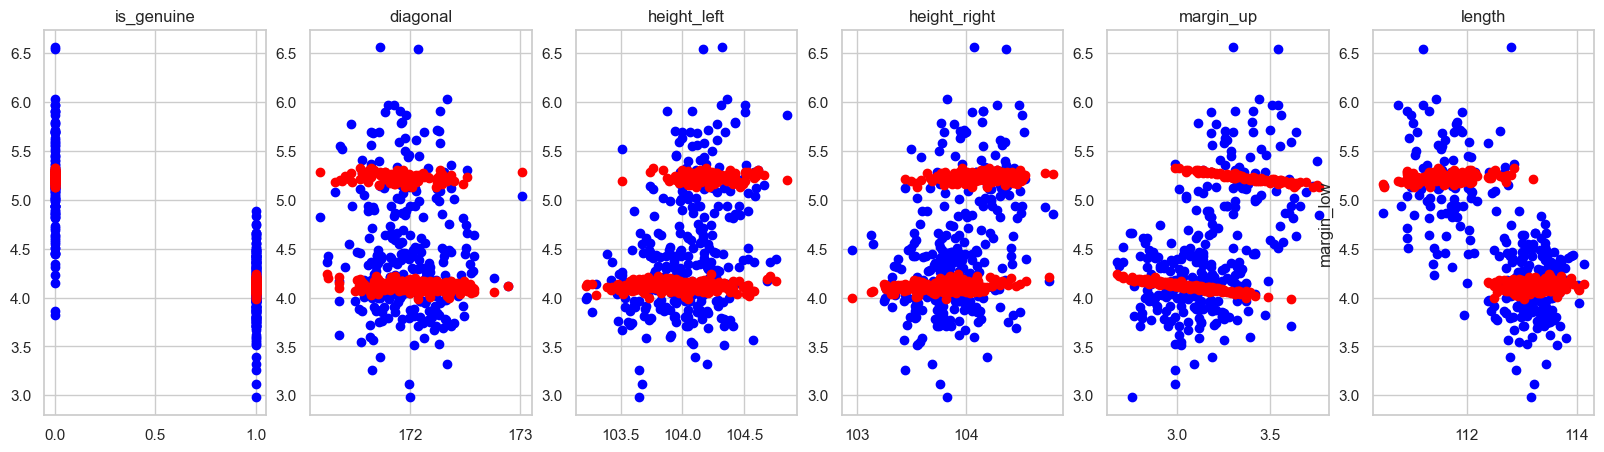

In [128]:
# Visualisation de ces predictions en rouge VS valeurs réelles en bleu sur le dataset d'entrainement (test). 

plt.figure(figsize=(20, 5))
features = ['is_genuine','diagonal', 'height_left','height_right','margin_up','length']

for i, col in enumerate(features):
    plt.subplot(1, len(features) , i+1)

    x_relle = X_test[col]
    y_relle = y_test
    y_predict = y_predict
    
    plt.scatter(x_relle, y_relle, marker='o', color="blue", label="original")
    plt.scatter(x_relle,y_predict, color="red", label="predicted" )
    plt.title(col)

plt.ylabel('margin_low')

> *Les prédictions (en rouge) que le modèle fait sur low_margin et les valeurs réelles (en bleu). Nous constatons qu'il y a des écarts conséquents, d'ou la faible fiabilité de ce modèle. Maintenant nous appliquons ce modèle à notre dataset des valeurs manquantes pour les remplacer par les prédictions :*

<h3 align="center"> <font color='#CF8305'> 3. Application du modèle sur nos valeurs manquantes </font>  <h3> 

In [129]:
# Préparation du dataset de test ou ils nous manquent les valeurs margin_low
X_test = df_Nan.drop(['margin_low'], axis=1)
y_test = df_Nan['margin_low']

# Application du modèle sur notre df de test final
model.predict(X_test)

array([4.05616477, 4.11342549, 4.14181531, 3.99143955, 4.1380579 ,
       4.10321069, 4.07447967, 4.13784406, 4.07227656, 4.06818232,
       4.10334472, 4.20988012, 4.14679884, 4.04663226, 4.18906754,
       4.2504654 , 4.1126777 , 4.09894946, 4.07559929, 4.08923679,
       4.12733658, 4.17128385, 4.16890731, 4.13013332, 4.13988393,
       4.22034897, 4.10843603, 4.10264077, 4.1341502 , 5.28894823,
       5.29792346, 5.31042286, 5.31601451, 5.220419  , 5.17149235,
       5.17377992, 5.26594203])

Text(0, 0.5, 'margin_low')

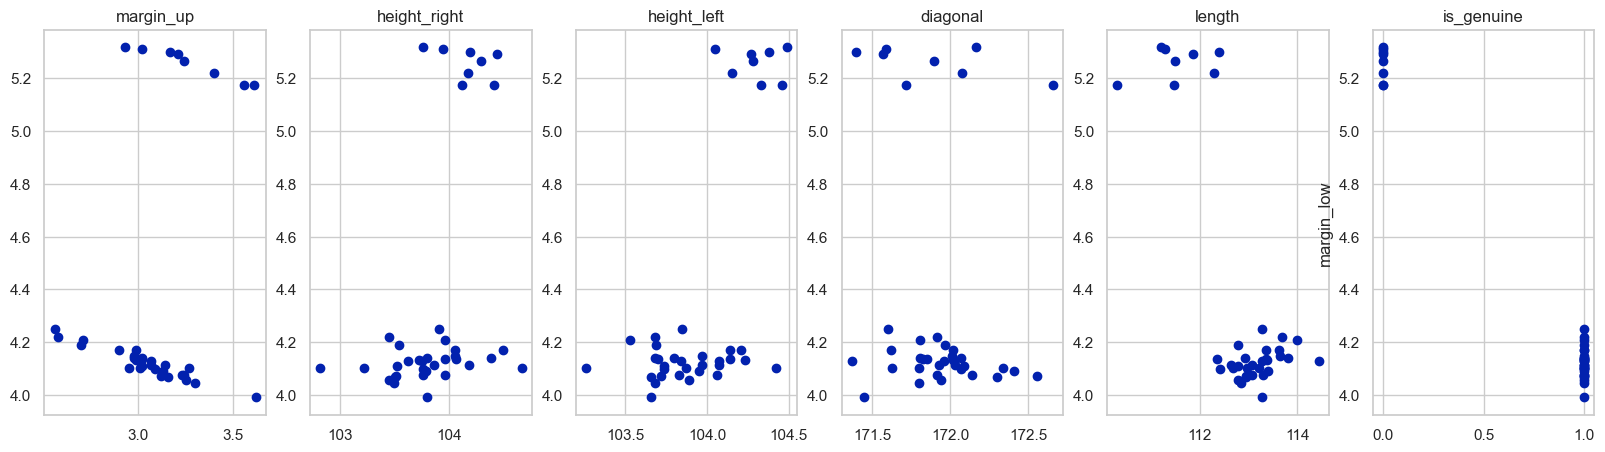

In [130]:
# Visualisation de ces predictions sur margin_up, height_right, height_left

plt.figure(figsize=(20, 5))
features = ['margin_up', 'height_right', 'height_left','diagonal','length', 'is_genuine']
target = model.predict(X_test)

for i, col in enumerate(features):
    plt.subplot(1, len(features) , i+1)

    x = df_Nan[col]
    y = target

    plt.scatter(x, y, marker='o', color="#0221AE")
    plt.title(col)

plt.ylabel('margin_low')

> *On applique ce modèle sur nos valeurs manquantes, on peut voir les valeurs prédites des valeurs manquantes de margin_low.*

<h3 align="center"> <font color='#CF8305'> 4. Remplacement des valeurs manquantes par les valeurs prédites, création du dataset final </font>  <h3> 

> *On remplace les valeurs manquantes par les valeurs prédites par le modèle. maintenant on a notre table de travail complète prête à être utilisée.*

In [131]:
# Remplacement des valeurs prédites dans mon df df_Nan ayant que les billets ou nous avons pas les valeurs de margin_low

df_Nan['margin_low'] = model.predict(X_test)
df_Nan

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,1,171.94,103.89,103.45,4.056165,3.25,112.79
99,1,171.93,104.07,104.18,4.113425,3.14,113.08
151,1,172.07,103.80,104.38,4.141815,3.02,112.93
197,1,171.45,103.66,103.80,3.991440,3.62,113.27
241,1,171.83,104.14,104.06,4.138058,3.02,112.36
251,1,171.80,103.26,102.82,4.103211,2.95,113.22
284,1,171.92,103.83,103.76,4.074480,3.23,113.29
334,1,171.85,103.70,103.96,4.137844,3.00,113.36
410,1,172.56,103.72,103.51,4.072277,3.12,112.95
413,1,172.30,103.66,103.50,4.068182,3.16,112.95


In [132]:
# Concaténer nos deux dataframe (df_SNan n'ayant pas les valeurs manquantes et df_Nan ayant les valeurs manquantes 
# remplacés par notre modèle) et trie de nos index pur garder la même structure que notre df d'origine

df_final = pd.concat([df_SNan,df_Nan])
df_final.sort_index(ascending=True, inplace=True)

# Arrondit à 2 décimales derrière pour la variable margin_low
df_final['margin_low'] = round(df_final['margin_low'],2)

# Visuel de notre table finale de travail
df_final.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1,171.46,103.36,103.66,3.77,2.99,113.09
2,1,172.69,104.48,103.50,4.40,2.94,113.16
3,1,171.36,103.91,103.94,3.62,3.01,113.51
4,1,171.73,104.28,103.46,4.04,3.48,112.54


<h1 align="center"> <font color='#CF8305'> IV. Création de modèles annoncants l'authenticité d'un billet </font> <h1> 

> *L'objectif est d'entrainer un modèle sur nos données pour prédire l'authenticité du billet en fonctions de ses caractéristiques. Ici l'authenticité du billet (vrai / faux) , la variable cible "is_genuine" est catégorique comme oui/non, réussite/échec.*

> *Il existe différents modèles capable d'être utilisé dans notre cas. Ils sont classés en deux catégories : les modèles supervisés et les modèles non supervisés. Leurs différences s'effectuent au niveau de leurs apprentissages: Les modèles par apprentissage supervisés consiste a récupérer des données dites annotées de leurs sorties pour entrainer le modèle, CAD on leur a déjà associé une classe cible et on voudrait que l’algorithme devienne capable une fois entrainée de prédire cette cible sur de nouvelles données. Ici nous allons retrouver la régression logistique, le K plus proches voisins, et la fôret d'arbres décisionnels. Quant aux modèles par apprentissage non supervisés : Les données d’entrées ne sont pas annotées. Ici nous retrouvons le K-means*

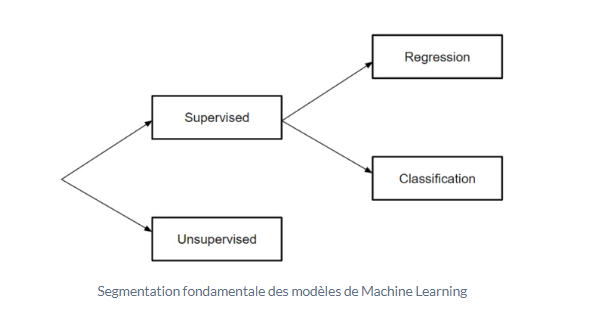

<h2 align="center"> <font color='#CF8305'>A. Modèle de régression linéaire logistique multiple </font> <h2> 

> *Ici on utilise une régression linéaire logistique dite multiple car nous prenons plusieurs variables dans notre matrice X d'entrainement du modèle. La régression logistique est semblable à la régression linéaire, mais elle est utilisée pour modéliser la probabilité d’un nombre fini de résultats, généralement deux (vrais et faux). Une équation logistique est créée de telle sorte que les valeurs des résultats ne peuvent être qu’entre 0 et 1.*

<h4 align="center"> <font color='#CF8305'>Création des dataset pour le modèle </font> <h4> 

In [133]:
# définir notre variable dépendante y et nos variables indépendantes X
X = df_final.iloc[:,[1,2,3,4,5,6]].values
y = df_final.iloc[:,[0]].values

In [134]:
# divisier le dataset entre le training set et le test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

> *Ici on normalise pour notre modèle de regression logistique, même si toutes nos features sont sur la même échelle en millimètre car on a apercu une amélioration de notre modèle avec.*

In [135]:
# On normalise nos df X d'entrainement et de test

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test_NO_SC = X_test
X_test = sc.fit_transform(X_test)

<h4 align="center"> <font color='#CF8305'>Création du modèle </font> <h4> 

In [136]:
# Construction du modèle

model_RL = LogisticRegression(random_state = 1, solver = 'liblinear')
model_RL.fit(X_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

<h4 align="center"> <font color='#CF8305'>Evaluation des performances du modèle </font> <h4> 

In [137]:
Error_RL = round((1 - model_RL.score(X_test,y_test)),3)
print('Erreur :',  Error_RL,'%')
Success_RL = round(model_RL.score(X_test,y_test),3)
print('Reussite :', Success_RL, '%')

Erreur : 0.003 %
Reussite : 0.997 %


In [138]:
# Vérifie combiens de mauvaises valeurs ont étés prédites : ici 1 / 300. 
y_pred = model_RL.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[ 97,   1],
       [  0, 202]], dtype=int64)

> *On obtient sur nos données de test un taux de réussite de 99,7%, nous avons qu'une seule mauvaise prédictions sur les 300 billets du dataset de test.*

<h5 align="center"> <font color='#CF8305'>Identification de cette mauvaise prédiction </font> <h5> 

In [139]:
features = ['diagonal', 'height_left','height_right','margin_low','margin_up','length']
df_pred = pd.DataFrame(data=X_test_NO_SC, columns=features)
df_pred['is_genuine'] = y_test
df_pred['prediction_RL'] = y_pred
df_pred.loc[(df_pred['is_genuine']==0) & (df_pred['prediction_RL']==1),:]

,diagonal,height_left,height_right,margin_low,margin_up,length,is_genuine,prediction_RL
109,172.02,103.99,104.28,4.22,2.98,112.42,0,1


> *On identifie cette mauvaise prédiction, ils'agit d'un faux positif c'est à dire que ce billet est considéré comme un vrai alors qu'il est faux.*

<h2 align="center"> <font color='#CF8305'>B. Modèle de clustering avec K-means </font> <h2> 

> *L'algorithme des K-moyenne permet d'analyser un jeu de données caractérisées par des variables, afin de regrouper les données “similaires” en groupes (ou clusters). Il faut lui spécifier le nombre K de cluster souhaité.*

<h4 align="center"> <font color='#CF8305'>Création des dataset pour le modèle </font> <h4> 

> *Ici pour ce modèle je n'ai pas besoin de normaliser car toutes mes variables explicatives (hors cible) sont sur la même échelle  en millimètre.*

In [140]:
# Création des dataframes

# Création d'un nouveau df spécifique pour ce modèle de ML
df_Kmeans = df_final.copy()
df_Kmeans.reset_index(drop=True, inplace=True)

# Création de deux df, un d'entrainement, un de test
df_train = df_Kmeans.sample(frac=0.8,
                random_state = 1)
not_in_train = ~df_Kmeans.index.isin(df_train.index)
df_test = df_Kmeans[not_in_train]

# Création de mes matrices X_train, X_test, y_train, y_test : définir notre variable dépendante y et nos variables indépendantes X

X_train = df_train.iloc[:,[1,2,3,4,5,6]].values
y_train = df_train.iloc[:,[0]].values
X_test = df_test.iloc[:,[1,2,3,4,5,6]].values
y_test = df_test.iloc[:,[0]].values

<h4 align="center"> <font color='#CF8305'>Choix du nombre de cluster </font> <h4> 

> *Pour choisir le nombre K de cluster on peut se référer à plusieurs méthodes :*

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


[0.5150332297377974,
 0.2206521607129923,
 0.1693909740828282,
 0.15433580782923237,
 0.1531680033251674,
 0.15774919342750965,
 0.16014021872902917,
 0.15790089701520776]

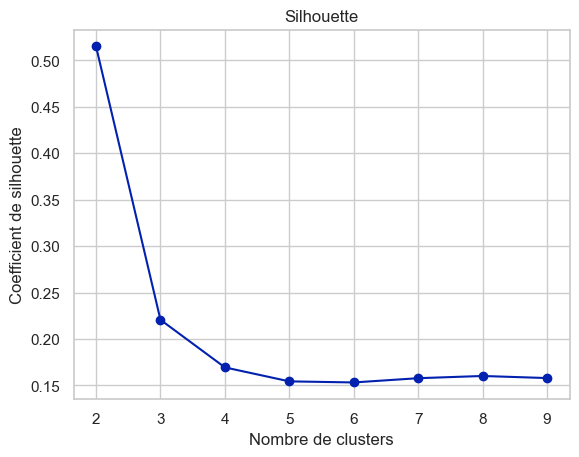

In [141]:
# Methode silhouette :
%pylab inline
np.random.seed(1)
silhouettes =[]
for num_clusters in range(2,10):
    cls = cluster.KMeans(n_clusters=num_clusters,
                        n_init=1, init='random')
    cls.fit(X_train)
    silh = metrics.silhouette_score(X_train, cls.labels_)
    silhouettes.append(silh)

#Graphique:
plt.title("Silhouette")
plt.xlabel("Nombre de clusters")
plt.ylabel("Coefficient de silhouette")
plt.plot(range(2,10), silhouettes, marker='o', color="#0221AE")
silhouettes

> *La méthode silhouette : Cette méthode permet d'évaluer la qualité des clusters créés grâce aux algorithmes de clustering. Compris entre [-1,1], le score silhouette est parfois utilisé pour trouver la valeur optimale du nombre de clusters « k ». Pour ce faire, on considère la valeur de « k » ayant le score de silhouette le plus proche de 1.*

> *Notre coefficient silhouette nous conseil de prendre K pour que le maximum du coefficient de silhouette soit atteint, ici on voit nettement qu'il nous indique de prendre 2 clusters ou le coefficient est de 0.5*

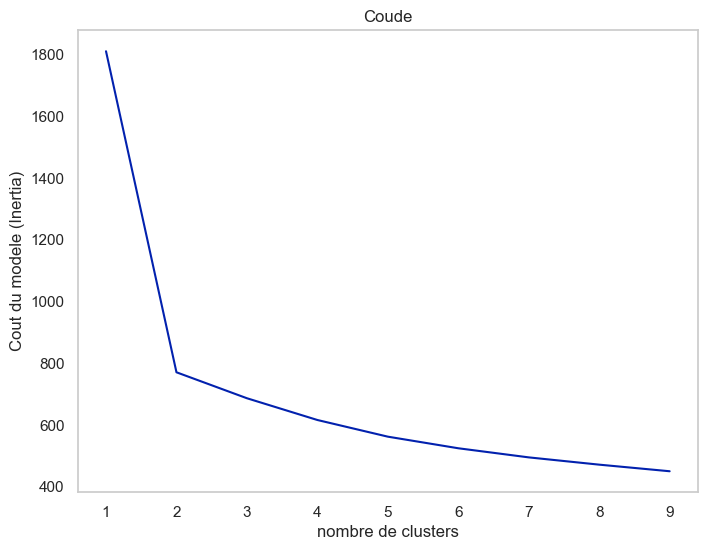

In [142]:
# Méthode du coude :
np.random.seed(1)
inertia = []
k_range=range(1,10)
for k in k_range:
    model=KMeans(n_clusters=k).fit(X_train)
    inertia.append(model.inertia_)

# Graphique:
fig = plt.figure(figsize=(8,6))
plt.plot(k_range,inertia, color="#0221AE" )
plt.title("Coude")
plt.xlabel('nombre de clusters')
plt.ylabel('Cout du modele (Inertia)')
plt.grid()
plt.show()

> *méthode du coude : Il existe une méthode populaire connue sous le nom de « The Elbow method » ou la méthode du coude qui est utilisée pour déterminer la valeur optimale de k. L’emplacement d’une courbe (coude) dans le graphique est généralement considéré comme un indicateur du nombre approprié de groupes. Les distances ne varient plus rapidement après cette inflexion, c'est-à-dire qu'une augmentation de k n'aura pas un grand effet sur les distances entre les points de données et leurs centroïdes respectives. Par conséquent, nous pouvons estimer à cet endroit, que l'on arrive à la valeur optimale de K. Ici on apercoit une grosse flexion à partir de K=2.*

<h4 align="center"> <font color='#CF8305'>Création du modèle </font> <h4> 

In [143]:
# Construction du modèle sur le jeu d'entrainement
np.random.seed(1)
model_KM = KMeans(n_clusters=2)
model_KM.fit(X_train)
clusters_k2 = model_KM.labels_ # recupération du cluster issu par Kmeans
centroids_k2 = model_KM.cluster_centers_ #et des centroides

In [144]:
# On ajoute le label du cluster
df_train['clusters_Kmeans']=clusters_k2

# On switch les valeurs du cluster 0-->1 / 1-->0 pour être en harmonie avec is_genuine
df_train['clusters_Kmeans'] = df_train['clusters_Kmeans'].replace(to_replace=0, value=2)
df_train['clusters_Kmeans'] = df_train['clusters_Kmeans'].replace(to_replace=1, value=0)
df_train['clusters_Kmeans'] = df_train['clusters_Kmeans'].replace(to_replace=2, value=1)


#on compte le nb de billets par n° de cluster et type de billets pour attribuer le type à chaque cluster
df_train_clusters_k2 =df_train.groupby(['clusters_Kmeans','is_genuine'])['diagonal'].count().reset_index(name='Count')
print('voici le détail par cluster du nb de billets vrais et faux:')
df_train_clusters_k2

voici le détail par cluster du nb de billets vrais et faux:


,clusters_Kmeans,is_genuine,Count
0,0,0,370
1,1,0,19
2,1,1,811


In [145]:
Nb_Vrai_FauxBillet_df_train = len(df_train.loc[(df_train['clusters_Kmeans']==0) & (df_train['is_genuine']==0),:])
Nb_Faux_FauxBillet_df_train = len(df_train.loc[(df_train['clusters_Kmeans']==1) & (df_train['is_genuine']==0),:])
Nb_Faux_VraiBillet_df_train = len(df_train.loc[(df_train['clusters_Kmeans']==0) & (df_train['is_genuine']==1),:])
Nb_Vrai_VraiBillet_df_train = len(df_train.loc[(df_train['clusters_Kmeans']==1) & (df_train['is_genuine']==1),:])
Nb_negatif_df_train = Nb_Faux_FauxBillet_df_train + Nb_Faux_VraiBillet_df_train
Nb_df_train = len(df_train)
Error_KM_train = round((Nb_negatif_df_train / Nb_df_train)*100,2)
Success_KM_train = round(((Nb_df_train-Nb_negatif_df_train)/Nb_df_train)*100,2)

print("le modèle de K-means appliqué au jeu d'entrainement prédit:")
print('- le nb de vrai positif de vrai billet est de',Nb_Vrai_VraiBillet_df_train)
print('- le nb de vrai négatif de faux billet est de',Nb_Vrai_FauxBillet_df_train)
print('- le nb de faux positif de vrai billet est de',Nb_Faux_VraiBillet_df_train)
print('- le nb de faux négatif de faux billet est de',Nb_Faux_FauxBillet_df_train)
print("le pourcentage d'erreur du modèle kmeans est donc de", Error_KM_train,'%')
print("le pourcentage de réussite du modèle kmeans est donc de", Success_KM_train,'%')

le modèle de K-means appliqué au jeu d'entrainement prédit:
- le nb de vrai positif de vrai billet est de 811
- le nb de vrai négatif de faux billet est de 370
- le nb de faux positif de vrai billet est de 0
- le nb de faux négatif de faux billet est de 19
le pourcentage d'erreur du modèle kmeans est donc de 1.58 %
le pourcentage de réussite du modèle kmeans est donc de 98.42 %


> *Sur le dataset d'entrainement, on apercoit qu'il y a 19 faux négatif soit un pourcentage de réussite du modèle de 98.42%.
On va appliquer ce modèle sur le dataset de test pour comparer.*

<h4 align="center"> <font color='#CF8305'>Application du modèle sur mon dataset de test </font> <h4> 

In [146]:
# Entrainement du modèle sur notre jeu de données
np.random.seed(1)
clusters_k2_test = model_KM.predict(X_test)

In [147]:
# On ajoute le label du cluster
df_test['clusters_Kmeans']=clusters_k2_test

# On switch les valeurs du cluster 0-->1 / 1-->0 pour être en harmonie avec is_genuine
df_test['clusters_Kmeans'] = df_test['clusters_Kmeans'].replace(to_replace=0, value=2)
df_test['clusters_Kmeans'] = df_test['clusters_Kmeans'].replace(to_replace=1, value=0)
df_test['clusters_Kmeans'] = df_test['clusters_Kmeans'].replace(to_replace=2, value=1)

In [148]:
# On compte le nb de billets par n° de cluster et type de billets pour attribuer le type à chaque cluster
df_test_clusters_k2 =df_test.groupby(['clusters_Kmeans','is_genuine'])['diagonal'].count().reset_index(name='Count')
print('voici le détail par cluster du nb de billets vrais et faux:')
df_test_clusters_k2

voici le détail par cluster du nb de billets vrais et faux:


,clusters_Kmeans,is_genuine,Count
0,0,0,108
1,0,1,2
2,1,0,3
3,1,1,187


In [149]:
Nb_Vrai_FauxBillet_df_test = len(df_test.loc[(df_test['clusters_Kmeans']==0) & (df_test['is_genuine']==0),:])
Nb_Faux_FauxBillet_df_test = len(df_test.loc[(df_test['clusters_Kmeans']==1) & (df_test['is_genuine']==0),:])
Nb_Faux_VraiBillet_df_test = len(df_test.loc[(df_test['clusters_Kmeans']==0) & (df_test['is_genuine']==1),:])
Nb_Vrai_VraiBillet_df_test = len(df_test.loc[(df_test['clusters_Kmeans']==1) & (df_test['is_genuine']==1),:])
Nb_negatif_df_test = Nb_Faux_FauxBillet_df_test + Nb_Faux_VraiBillet_df_test
Nb_df_test = len(df_test)
Error_KM = round((Nb_negatif_df_test / Nb_df_test)*100,2)
Success_KM = round(((Nb_df_test-Nb_negatif_df_test)/Nb_df_test)*100,2)

print("le modèle de K-means appliqué au jeu d'entrainement prédit:")
print('- le nb de vrai positif de vrai billet est de',Nb_Vrai_VraiBillet_df_test)
print('- le nb de vrai négatif de faux billet est de',Nb_Vrai_FauxBillet_df_test)
print('- le nb de faux positif de vrai billet est de',Nb_Faux_VraiBillet_df_test)
print('- le nb de faux négatif de faux billet est de',Nb_Faux_FauxBillet_df_test)
print("le pourcentage d'erreur du modèle kmeans est donc de", Error_KM,'%')
print("le pourcentage de réussite du modèle kmeans est donc de", Success_KM,'%')

le modèle de K-means appliqué au jeu d'entrainement prédit:
- le nb de vrai positif de vrai billet est de 187
- le nb de vrai négatif de faux billet est de 108
- le nb de faux positif de vrai billet est de 2
- le nb de faux négatif de faux billet est de 3
le pourcentage d'erreur du modèle kmeans est donc de 1.67 %
le pourcentage de réussite du modèle kmeans est donc de 98.33 %


> *Sur le dataset de test, on apercoit qu'il y a 2 faux positif et 3 faux négatif soit un pourcentage de réussite du modèle de 98.33%, tout comme sur le dataset d'entrainement. On peut donc observer qu'il n'y a ni sous-apprentiussage ni sur-apprentissage du modèle.*

> *On va regarder visuellement sur deux variables les prédictions et les valeurs réelles du dataset de test. 
Les 5 mauvaises prédictions sont des billets qui peuvent facilement porter a confusion pour le modèle comme on peut le voir dans cet exemple sur ces variables length et margin low.*

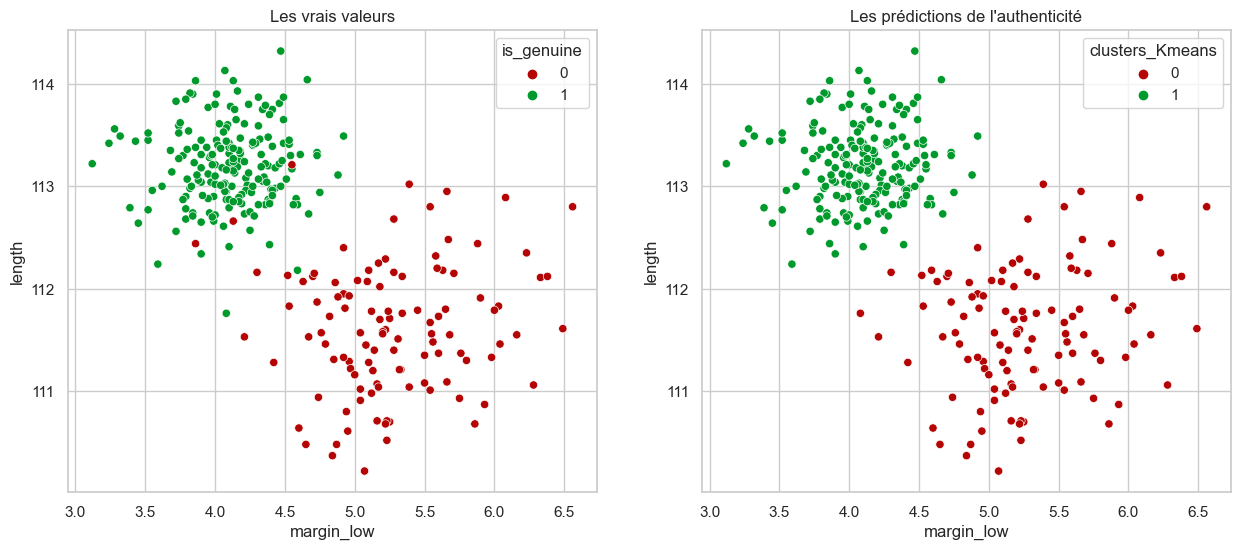

In [150]:
# Visuellement sur deux variables : lentgh et margin_low (les 2 variables les plus corrélés entre elles)


plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
sns.scatterplot(df_test, x='margin_low', y='length', hue='is_genuine', palette=["#b50404","#00992C"])
plt.title('Les vrais valeurs')

plt.subplot(1,2,2)
sns.scatterplot(df_test, x='margin_low', y='length', hue='clusters_Kmeans', palette=["#b50404","#00992C"])
plt.title("Les prédictions de l'authenticité")


plt.show()

<h5 align="center"> <font color='#CF8305'>Identification des mauvaises prédictions </font> <h5> 

In [151]:
df_test.loc[(df_test['is_genuine']==0) & (df_test['clusters_Kmeans']==1),:]

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,clusters_Kmeans
1025,0,172.17,104.20,104.13,3.86,3.38,112.44,1
1160,0,172.39,104.05,104.32,4.13,3.41,112.66,1
1190,0,171.45,104.21,104.18,4.55,3.52,113.21,1


In [152]:
df_test.loc[(df_test['is_genuine']==1) & (df_test['clusters_Kmeans']==0),:]

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,clusters_Kmeans
591,1,171.67,103.81,103.76,4.59,3.30,112.18,0
728,1,171.94,104.11,104.16,4.08,3.35,111.76,0


> *Observation : aucunes de ces mauvaises prédictions ressemble à celui de la regression logistique.*

<h2 align="center"> <font color='#CF8305'>C. Modèle de K-NN </font> <h2> 

> *Pour le modèle des K plus proches voisins on va simplement regarder les k voisins les plus proches de ses variables et regarder quelle classe constitue la majorité de ces points, afin d'en déduire la classe du nouveau point. Par exemple ici si on utilise K=3, on peut prédire que la nouvelle donnée au centre du cercle violet appartient à la classe O. La particularité de ce modèle est de trouver le K optimal de voisins pour minimiser l'erreur sur les données de test.* 

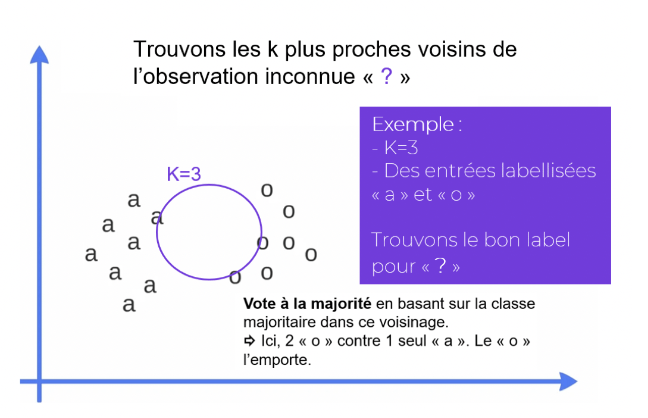

<h3 align="center"> <font color='#CF8305'> 1. Méthode classique </font> <h3> 

<h4 align="center"> <font color='#CF8305'> Création des dataset pour le modèle </font> <h4> 

In [153]:
# définir notre variable dépendante y et nos variables indépendantes X
X = df_final.iloc[:,[1,2,3,4,5,6]].values
y = df_final.iloc[:,[0]].values

In [154]:
# divisier le dataset entre le training set et le test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

> *Ici pour ce modèle je n'ai pas besoin de normaliser car toutes mes variables explicatives (hors cible) sont sur la même échelle  en millimètre.*

<h4 align="center"> <font color='#CF8305'> Choix du nombre de K voisins </font> <h4> 

> *Pour trouver le k optimal, on va simplement tester le modèle pour tous les k de 1 à 15, mesurer l’erreur test et afficher la performance en fonction de k :*

In [155]:
test_error_rates = []
for k in range (1,15):
    model_KNN = KNeighborsClassifier(n_neighbors=k)
    model_KNN.fit(X_train, y_train)
    
    y_pred_test = model_KNN.predict(X_test)
    test_error = 1- accuracy_score(y_test, y_pred_test)
    test_error_rates.append(test_error)

Text(0.5, 0, 'K voisins')

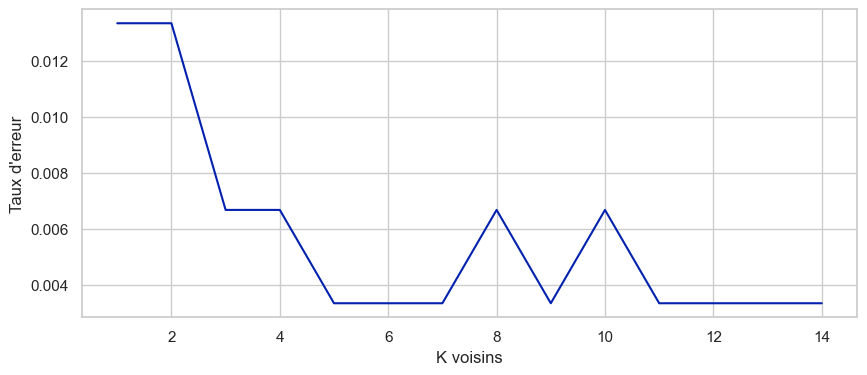

In [156]:
# Graphique : 

plt.figure(figsize=(10, 4))
plt.plot(range(1,15),test_error_rates, color="#0221AE")
plt.ylabel("Taux d'erreur")
plt.xlabel('K voisins')

> *On doit tjr considéré le compromis entre la performance du modèle et la complexité de ce dernier, mais ici 3 K est la valeur optimal pour la performance et la complexité n'est pas grande.*

<h4 align="center"> <font color='#CF8305'> Création du modèle à partir de K </font> <h4> 

In [157]:
# Construction du modèle

model_KNN = neighbors.KNeighborsClassifier(n_neighbors=5)
model_KNN.fit(X_train,y_train)

KNeighborsClassifier()

<h4 align="center"> <font color='#CF8305'> Evaluation des performances du modèle </font> <h4> 

In [158]:
Error_KNN = round((1 - model_KNN.score(X_test,y_test)),3)
print('Erreur :',  Error_KNN,'%')
Success_KNN = round(model_KNN.score(X_test,y_test),3)
print('Reussite :', Success_KNN, '%')

Erreur : 0.003 %
Reussite : 0.997 %


In [159]:
# Vérifie combiens de mauvaises valeurs ont étés prédites : ici 1 / 300. 

y_pred = model_KNN.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[ 97,   1],
       [  0, 202]], dtype=int64)

<h5 align="center"> <font color='#CF8305'>Identification de cette mauvaise prédiction </font> <h5> 

In [160]:
features = ['diagonal', 'height_left','height_right','margin_low','margin_up','length']
df_pred = pd.DataFrame(data=X_test_NO_SC, columns=features)
df_pred['is_genuine'] = y_test
df_pred['prediction_KNN'] = y_pred
df_pred.loc[(df_pred['is_genuine']==0) & (df_pred['prediction_KNN']==1),:]

,diagonal,height_left,height_right,margin_low,margin_up,length,is_genuine,prediction_KNN
109,172.02,103.99,104.28,4.22,2.98,112.42,0,1


<h3 align="center"> <font color='#CF8305'> 2. Méthode avec GridSearch </font> <h3> 

> *J'ai proposé une autre méthode pour utiliser le modèle du KNN. Gridsearch cv permet de trouver le modele avec les meilleurs hyperparamètres en comparant différentes performances de chaque combinaisons grâce a la technique de cross validation. Je vais passer dessus car les paramètres changent très peu par rapport au modèle construit juste avant et les résultats sont identiques.*

<h4 align="center"> <font color='#CF8305'> Création des dataset pour le modèle </font> <h4> 

In [161]:
# définir notre variable dépendante y et nos variables indépendantes X
X = df_final.iloc[:,[1,2,3,4,5,6]].values
y = df_final.iloc[:,[0]].values

In [162]:
# divisier le dataset entre le training set et le test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

<h4 align="center"> <font color='#CF8305'> Création du modèle </font> <h4> 

In [163]:
# On définit nos paramètres
knn = KNeighborsClassifier()
sc = StandardScaler()
operations=[('scaler', sc), ('knn',knn)]

# On définit notre transfomration
pipe = Pipeline(operations)

# On définit une liste de K
k_values =list(range(1,20))

# On définit nos hyperparamètres: 
param_grid = {'knn__n_neighbors':k_values}

# Notre GridSearchCv
full_cv_classifier = GridSearchCV(pipe,param_grid,cv=5,scoring='accuracy')

# On l'applique sur nos données d'entrainements
full_cv_classifier.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19]},
             scoring='accuracy')

In [164]:
# On regarde les paramètres de l'estimateur le plus optimal :  ici K=7 --> rajoute de la complexité au modèle par rapport à K=5.

full_cv_classifier.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('knn', KNeighborsClassifier(n_neighbors=6))],
 'verbose': False,
 'scaler': StandardScaler(),
 'knn': KNeighborsClassifier(n_neighbors=6),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 6,
 'knn__p': 2,
 'knn__weights': 'uniform'}

In [165]:
# On créait notre modèle avec le meilleur estimateur obtenu

model_KNN_GS = full_cv_classifier.best_estimator_

<h4 align="center"> <font color='#CF8305'> Evaluation des performances du modèle </font> <h4> 

In [166]:
Error_KNN_GS = round((1 - model_KNN_GS.score(X_test,y_test)),3)
print('Erreur :',  Error_KNN_GS,'%')
Success_KNN_GS = round(model_KNN_GS.score(X_test, y_test),3)
print('Reussite :', Success_KNN_GS, '%')

Erreur : 0.007 %
Reussite : 0.993 %


In [167]:
# Vérifie combiens de mauvaises valeurs ont étés prédites : ici 1 / 300. 

y_pred = model_KNN_GS.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[ 97,   1],
       [  1, 201]], dtype=int64)

<h5 align="center"> <font color='#CF8305'>Identification de cette mauvaise prédiction </font> <h5> 

In [168]:
features = ['diagonal', 'height_left','height_right','margin_low','margin_up','length']
df_pred = pd.DataFrame(data=X_test_NO_SC, columns=features)
df_pred['is_genuine'] = y_test
df_pred['prediction_KNN'] = y_pred
df_pred.loc[(df_pred['is_genuine']==0) & (df_pred['prediction_KNN']==1),:]

,diagonal,height_left,height_right,margin_low,margin_up,length,is_genuine,prediction_KNN
109,172.02,103.99,104.28,4.22,2.98,112.42,0,1


> *Observation : Il sagit de la même mauvaise prédiction que le modèle classique du KNN avait réalisé. Avec des paramètres différents sur les deux modèles de KNN on arrive au même taux de succès du modèle. On a pu découvrir une autre approche de ce modèle.*

<h2 align="center"> <font color='#CF8305'> D. Modèle de random forest </font> <h2> 

> *Le modèle de la fôret d'arbres décisionnels ou random forest s’appuie sur des arbres de décision. Il créait de multiples arbres décisionnels en utilisant un ensembles de données fractionnés à partir des données d’origine.*

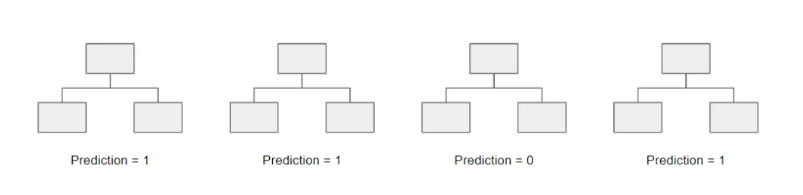

<h4 align="center"> <font color='#CF8305'> Créations des dataset pour le modèle </font> <h4> 

> *Ici pour ce modèle je n'ai pas besoin de normaliser car toutes mes variables explicatives (hors cible) sont sur la même échelle  en millimètre.*

In [169]:
# définir notre variable dépendante y et nos variables indépendantes X
X = df_final.iloc[:,[1,2,3,4,5,6]].values
y = df_final.iloc[:,[0]].values

# divisier le dataset entre le training set et le test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)
df_pred = X_test

<h4 align="center"> <font color='#CF8305'> Création du modèle </font> <h4> 

In [170]:
# Construction du modèle

model_RFC = RandomForestClassifier(max_depth=2, random_state=0)
model_RFC.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, random_state=0)

Text(0.5, 1.0, 'Importance de la contribution des variables')

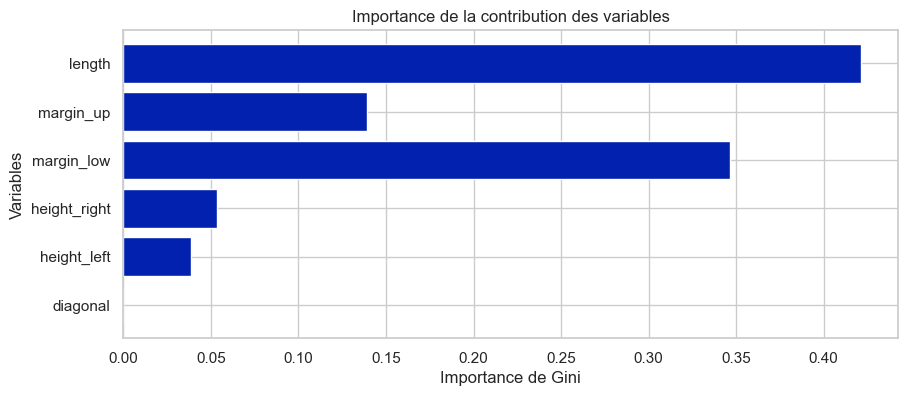

In [171]:
# Graphique : 

plt.figure(figsize=(10, 4))
plt.barh(features, model_RFC.feature_importances_, color="#0221AE")
plt.ylabel("Variables")
plt.xlabel('Importance de Gini')
plt.title('Importance de la contribution des variables')

> *En bonus nous pouvons voir l'importance des variables lors de l'utilisation de ce modèle. On apercoit que la variable diagonal ne contribue quasiment pas (1.79017051e-04) à ce modèle*

<h4 align="center"> <font color='#CF8305'> Evaluation des performances du modèle </font> <h4> 

In [172]:
Error_RFC = round((1 - model_RFC.score(X_test,y_test)),3)
print('Erreur :',  Error_RFC,'%')
Success_RFC = round(model_RFC.score(X_test,y_test),3)
print('Reussite :', Success_RFC, '%')

Erreur : 0.003 %
Reussite : 0.997 %


In [173]:
# Vérifie combiens de mauvaises valeurs ont étés prédites : ici 1 / 300. 
y_pred = model_RFC.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[ 97,   1],
       [  0, 202]], dtype=int64)

> *On obtient sur nos données de test un taux de réussite de 99,7%, nous avons qu'une seule mauvaise prédictions sur les 300 billets du dataset de test.*

<h5 align="center"> <font color='#CF8305'>Identification de cette mauvaise prédiction </font> <h5> 

In [174]:
features = ['diagonal', 'height_left','height_right','margin_low','margin_up','length']
df_pred = pd.DataFrame(data=X_test, columns=features)
df_pred['is_genuine'] = y_test
df_pred['prediction_RFC'] = y_pred
df_pred.loc[(df_pred['is_genuine']==0) & (df_pred['prediction_RFC']==1),:]

,diagonal,height_left,height_right,margin_low,margin_up,length,is_genuine,prediction_RFC
109,172.02,103.99,104.28,4.22,2.98,112.42,0,1


> *Observation : Cette mauvaise prédiction correspond au même billet que celui obtenu de la regression logistique et du KNN. On analyse ce faux billet pour comprendre pourquoi les 3 modèles le prédisent mal :*

In [175]:
df.loc[(df['diagonal']==172.02) & (df['height_left']==103.99),:]

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
1407,0,172.02,103.99,104.28,4.22,2.98,112.42


In [176]:
df['Mauvaise_prediction'] = 0
df.loc[(df['diagonal']==172.02) & (df['height_left']==103.99),['Mauvaise_prediction']] = '1'

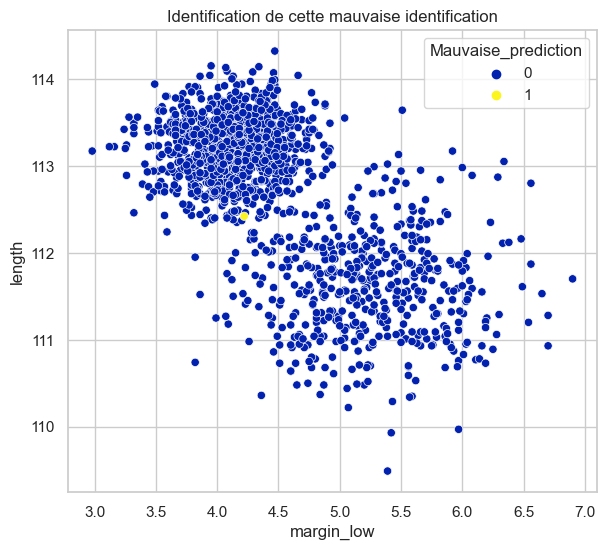

In [177]:
# Identification visuelle sur lentgh et margin_low 


plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
sns.scatterplot(df, x='margin_low', y='length', hue='Mauvaise_prediction', palette=["#0221AE","#FCF51D"])
plt.title('Identification de cette mauvaise identification')
plt.show()

In [178]:
df.loc[(df['diagonal']==172.02) & (df['height_left']==103.99),['is_genuine']] = '2'

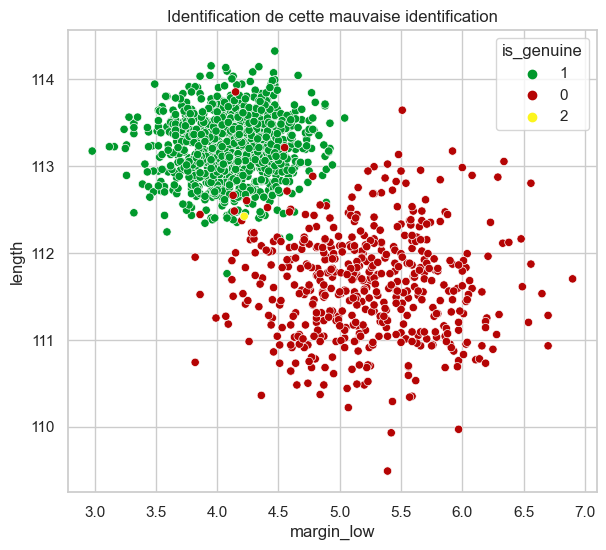

In [179]:
# Identification visuelle sur lentgh et margin_low 


plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
sns.scatterplot(df, x='margin_low', y='length', hue='is_genuine', palette=["#00992C","#b50404","#FCF51D"])
plt.title('Identification de cette mauvaise identification')
plt.show()

> *Après analyse des variables et des graphiques on s'apercoit que ce billet a des caractéristiques proches des moyennes de chaque type de billet d'ou la confusion des modèles.* 

<h1 align="center"> <font color='#CF8305'>V. Prédiction nouveau jeu de données</font> <h1> 

> *Maintenant on va pouvoir prédire les nouveaux billets avec les différents modèles vu ensemble. 
Un premier test a été effectué via un autre fichier de test pour paramétrer les futures prédictions.*

<h3 align="center"> <font color='#CF8305'>A. Fichier de test : FICHIER billets_production.csv</font> <h3> 

<h4 align="center"> <font color='#CF8305'>Importation du nouveau fichier</font> <h4> 

In [180]:
df_bonus = pd.read_csv('C:/Users/User/Desktop/Projet_10/Donnees/billets_production.csv', sep=',')

<h4 align="center"> <font color='#CF8305'> Mise en forme du Dataset</font> <h4> 

In [181]:
df_bonus

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [182]:
# Met en forme le dataset
df_bonus = df_bonus.set_index(df_bonus["id"])
df_bonus.drop(["id"], axis=1, inplace=True)

# Faire une copie pour chaque modèle
df_bonus_RL = df_bonus.copy()
df_bonus_Kmeans = df_bonus.copy()
df_bonus_KNN = df_bonus.copy()
df_bonus_RFC = df_bonus.copy()

In [183]:
# Regression logistique : prediction et ajout de la prediction, du taux de reussite du modèle et de la proba d'appartenance dans notre dataset
X_bonus = df_bonus_RL.values
X_bonus = sc.fit_transform(X_bonus)
df_bonus['Prediction_RL'] = model_RL.predict(X_bonus)
df_bonus['Taux_reussite_RL'] = Success_RL*100
df_bonus[['Pred_Proba_Classe0_RL','Pred_Proba_Classe1_RL']] = model_RL.predict_proba(X_bonus)

# K_means : prediction et ajout de la prediction et le taux de reussite du modèle dans notre dataset
X_bonus = df_bonus_Kmeans.values
array_predict = model_KM.predict(X_bonus)
# Inversement 1 et 0 car le cluster 0 correspond à 1 (billet vrai) et mon cluster 1 correspond à 0 (billet faux)
array_predict[array_predict == 0] = 2
array_predict[array_predict == 1] = 0
array_predict[array_predict == 2] = 1
df_bonus['Prediction_Kmeans'] = array_predict
df_bonus['Taux_reussite_Kmeans'] = round(Success_KM,1)

# KNN : prediction et ajout de la prediction et du taux de reussite du modèle
model_KNN.predict(df_bonus_KNN)
df_bonus['Prediction_KNN'] = model_KNN.predict(df_bonus_KNN)
df_bonus['Taux_reussite_KNN'] = Success_KNN*100

# RFC : prediction et ajout de la prediction, du taux de reussite du modèle et de la proba d'appartenance dans notre dataset
X_bonus = df_bonus_RFC.values
model_RFC.predict(X_bonus)
df_bonus['Prediction_RFC'] = model_RFC.predict(X_bonus)
df_bonus['Taux_reussite_RFC'] = Success_RFC*100
df_bonus[['Pred_Proba_Classe0_RFC','Pred_Proba_Classe1_RFC']] = model_RFC.predict_proba(X_bonus)

In [184]:
df_bonus.head()

,diagonal,height_left,height_right,margin_low,margin_up,length,Prediction_RL,Taux_reussite_RL,Pred_Proba_Classe0_RL,Pred_Proba_Classe1_RL,Prediction_Kmeans,Taux_reussite_Kmeans,Prediction_KNN,Taux_reussite_KNN,Prediction_RFC,Taux_reussite_RFC,Pred_Proba_Classe0_RFC,Pred_Proba_Classe1_RFC
id,,,,,,,,,,,,,,,,,,
A_1,171.76,104.01,103.54,5.21,3.30,111.42,0,99.7,0.964236,0.035764,0,98.3,0,99.7,0,99.7,0.877948,0.122052
A_2,171.87,104.17,104.13,6.00,3.31,112.09,0,99.7,0.990567,0.009433,0,98.3,0,99.7,0,99.7,0.929234,0.070766
A_3,172.00,104.58,104.29,4.99,3.39,111.57,0,99.7,0.992155,0.007845,0,98.3,0,99.7,0,99.7,0.942834,0.057166
A_4,172.49,104.55,104.34,4.44,3.03,113.20,1,99.7,0.000117,0.999883,1,98.3,1,99.7,1,99.7,0.122437,0.877563
A_5,171.65,103.63,103.56,3.77,3.16,113.33,1,99.7,0.000005,0.999995,1,98.3,1,99.7,1,99.7,0.037376,0.962624


<h3 align="center"><font color='#CF8305'> B. Fichier de test : Fichier de la soutenance </font> <h3> 

<h4 align="center"> <font color='#CF8305'> Importation du nouveau fichier </font> <h4> 

<h4 align="center"> <font color='#CF8305'> Mise en forme du Dataset </font>  <h4> 

In [185]:
df_soutenance = pd.read_csv('C:/Users/User/Desktop/Projet_10/Donnees/billets_test (5).csv', sep=',')
#df_soutenance_verif = pd.read_csv('C:/Users/User/Desktop/Projet_10/Donnees/FICHIER SOUTENANCE.csv', sep=',')

In [186]:
df_soutenance.head()

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,172.09,103.95,103.73,4.39,3.09,113.19,B_1
1,171.52,104.17,104.03,5.27,3.16,111.82,B_2
2,171.78,103.80,103.75,3.81,3.24,113.39,B_3
3,172.02,104.08,103.99,5.57,3.30,111.10,B_4
4,171.79,104.34,104.37,5.00,3.07,111.87,B_5


In [187]:
# Met en forme le dataset
df_soutenance = df_soutenance.set_index(df_soutenance["id"])
df_soutenance.drop(["id"], axis=1, inplace=True)

# Faire une copie pour chaque modèle
df_soutenance_RL = df_soutenance.copy()
df_soutenance_Kmeans = df_soutenance.copy()
df_soutenance_KNN = df_soutenance.copy()
df_soutenance_RFC = df_soutenance.copy()

In [188]:
# Regression logistique : prediction et ajout de la prediction, du taux de reussite du modèle et de la proba d'appartenance dans notre dataset
X_soutenance = df_soutenance_RL.values
X_soutenance = sc.fit_transform(X_soutenance)
df_soutenance['Prediction_RL'] = model_RL.predict(X_soutenance)
df_soutenance['Taux_reussite_RL'] = Success_RL*100
df_soutenance[['Pred_Proba_Classe0_RL','Pred_Proba_Classe1_RL']] = model_RL.predict_proba(X_soutenance)

# K_means : prediction et ajout de la prediction et le taux de reussite du modèle dans notre dataset
X_soutenance = df_soutenance_Kmeans.values
array_predict = model_KM.predict(X_soutenance)
# Inversement 1 et 0 car le cluster 0 correspond à 1 (billet vrai) et mon cluster 1 correspond à 0 (billet faux)
array_predict[array_predict == 0] = 2
array_predict[array_predict == 1] = 0
array_predict[array_predict == 2] = 1
df_soutenance['Prediction_Kmeans'] = array_predict
df_soutenance['Taux_reussite_Kmeans'] = round(Success_KM,1)

# KNN : prediction et ajout de la prediction et du taux de reussite du modèle
model_KNN.predict(df_soutenance_KNN)
df_soutenance['Prediction_KNN'] = model_KNN.predict(df_soutenance_KNN)
df_soutenance['Taux_reussite_KNN'] = Success_KNN*100

# RFC : prediction et ajout de la prediction, du taux de reussite du modèle et de la proba d'appartenance dans notre dataset
X_soutenance = df_soutenance_RFC.values
model_RFC.predict(X_soutenance)
df_soutenance['Prediction_RFC'] = model_RFC.predict(X_soutenance)
df_soutenance['Taux_reussite_RFC'] = Success_RFC*100
df_soutenance[['Pred_Proba_Classe0_RFC','Pred_Proba_Classe1_RFC']] = model_RFC.predict_proba(X_soutenance)

In [189]:
df_soutenance.head()

,diagonal,height_left,height_right,margin_low,margin_up,length,Prediction_RL,Taux_reussite_RL,Pred_Proba_Classe0_RL,Pred_Proba_Classe1_RL,Prediction_Kmeans,Taux_reussite_Kmeans,Prediction_KNN,Taux_reussite_KNN,Prediction_RFC,Taux_reussite_RFC,Pred_Proba_Classe0_RFC,Pred_Proba_Classe1_RFC
id,,,,,,,,,,,,,,,,,,
B_1,172.09,103.95,103.73,4.39,3.09,113.19,1,99.7,0.000051,0.999949,1,98.3,1,99.7,1,99.7,0.037254,0.962746
B_2,171.52,104.17,104.03,5.27,3.16,111.82,0,99.7,0.929824,0.070176,0,98.3,0,99.7,0,99.7,0.862944,0.137056
B_3,171.78,103.80,103.75,3.81,3.24,113.39,1,99.7,0.000031,0.999969,1,98.3,1,99.7,1,99.7,0.080667,0.919333
B_4,172.02,104.08,103.99,5.57,3.30,111.10,0,99.7,0.999794,0.000206,0,98.3,0,99.7,0,99.7,0.908732,0.091268
B_5,171.79,104.34,104.37,5.00,3.07,111.87,0,99.7,0.647445,0.352555,0,98.3,0,99.7,0,99.7,0.875021,0.124979
